In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as slinalg
%matplotlib inline

import sys
sys.path.append('../../module')
import gym2
import util as U

In [2]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01 * np.eye(1)
lam = .5

In [3]:
def array_exp(A):
    v, p = np.linalg.eig(A)
    align = np.array([[v[0], 0],[0, v[1]]])
    exp = np.exp(align)
    exp[~np.eye(exp.shape[0],dtype=bool)] = 0
    out = np.dot(np.dot(p, exp), np.linalg.inv(p))
    return out


def next_state(state, action, tau, env):
    # mean of next state when const action and tau is input
    A = env.A
    B = env.B
    eAt = array_exp(A*tau)
    A_inv = np.linalg.inv(A)
    
    integral = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
    s_prime = np.dot(eAt, state) + integral *action 
    
    return s_prime


def variance(A, D, tau):
    tmp = np.dot(array_exp(A*tau), D)
    Q = np.dot(D.reshape(2,1), D.reshape(1,2)) - np.dot(tmp, tmp)
    V = slinalg.solve_lyapunov(A, -Q)
    return V
    
    
def control_law(state, env, Q=Q, R=R, l=lam):
    A = env.A
    B = env.B
    D = env.D
    next_value_weight = 100
    
    taus = np.linspace(.01, 10., 1000)
    evaluation = np.inf
    
    # riccati
    P = slinalg.solve_continuous_are(A, B.reshape(B.shape[0],1), Q, R)
    A_inv = np.linalg.inv(A)
    
    for tau in taus:
        # calculate optimal action with fixed `tau`
        eAt = array_exp(A*tau)
        
        # ∂s'/∂u
        dsdu = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
        # int exp(A(t-τ))Budt
        integral = dsdu

        # ∂c/∂u = first + second * u, c: instant cost
        first = 2 * np.dot(np.dot(dsdu, P), np.dot(eAt, state))
        first *= next_value_weight
        second = 2 * np.dot(np.dot(dsdu, P), integral)
        second = next_value_weight * second + 2

        # optimal action
        u = - first / second
        
        # evaluation
        s_prime = next_state(state, u, tau, env)
        V_lqr = np.dot(np.dot(s_prime, P), s_prime) + np.trace(np.dot(P, variance(A, D, tau)))
        ev = u**2 - l * tau + next_value_weight * V_lqr
        #print(s_prime, ev, [u, tau])
        if ev < evaluation:
            control = np.array([u, tau])
            evaluation = ev
    
    return control

In [21]:
state = np.array([3.,3.])
control_law(state, env)

array([-1.07805532,  2.64      ])

In [18]:
l = 1.
env.reset()
initial_state = np.array([3., 3.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = control_law(x, env)
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=1)
        reward += r
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    print(env.state, tau)
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(control_law(env.state, env)[0])
states = np.array(states)
detail_states = np.array(detail_states)

[ 0.04740562 -0.77186929] 1.05
[-0.60171105 -0.84792991] 0.12
[-0.61168897 -0.81632355] 0.01
[-0.56419608 -0.72976217] 0.01
[-0.62233115 -0.75348912] 0.01
[-0.63568982 -0.73250674] 0.01
[-0.77794664 -0.84229335] 0.01
[-0.85270831 -0.21027406] 0.55
[-0.88368137 -0.14029942] 0.43
[0.07349818 0.31538668] 0.42000000000000004
[0.42642337 0.39627227] 0.16
[0.6056234 0.5603659] 0.01
[0.69046238 0.62392111] 0.01
[0.65429919 0.56454152] 0.01
[0.59584614 0.4859622 ] 0.01
[0.75839937 0.63216264] 0.01
[1.21920357 0.4609058 ] 0.5
[0.70029925 0.25805945] 0.5700000000000001
[1.28359554 0.75092876] 0.39
[ 0.40273146 -0.1853179 ] 0.63
[-0.03814363 -0.21375419] 0.21000000000000002
[-0.35687259 -0.29499453] 0.17
[-0.42700237 -0.35505386] 0.01
[-0.56576318 -0.48161861] 0.01
[-0.53507995 -0.43399098] 0.01
[-0.64699108 -0.53138628] 0.01
[-0.69084218 -0.55722046] 0.01
[-0.71477801 -0.56263288] 0.01
[1.51299158 1.2001924 ] 0.48000000000000004
[-0.15810972 -0.58307075] 0.73
[-0.21269103 -0.6014385 ] 0.01
[-0.2

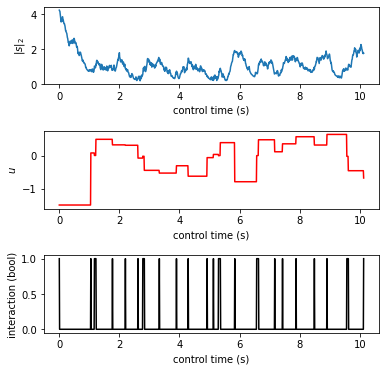

In [19]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [20]:
import warnings
warnings.filterwarnings('ignore')
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [21]:
actor = branch_actor((2,),(2,))
actor.compile(loss='mse', optimizer='adam')

In [22]:
# make train data
s1 = np.linspace(-7,7,100)
s2 = np.linspace(-7,7,100)
S1, S2 = np.meshgrid(s1, s2)
batch = []

for state in zip(S1.flatten(), S2.flatten()):
    state = np.array(state)
    action = control_law(state, env)
    batch.append([state, action])
    
batch = np.array(batch)

KeyboardInterrupt: 

In [ ]:
batch_size = 32

epochs = 10000
losses = []
for _ in range(epochs):
    indices = np.random.choice(range(10000),batch_size,replace=False)
    states = batch[:,0].reshape(10000,1,2)
    actions = batch[:,1]
    
    
    loss = actor.train_on_batch(states, actions)
    losses.append(loss)
    
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('actor_loss')
plt.show()


In [11]:
actor.save_weights('./saved_agent/mb_self_noisy_extend2_actor.h5')

In [13]:
actor.load_weights('./saved_agent/mb/mb_self_100_actor.h5')

In [16]:
l = .5
env.reset()
initial_state = np.array([3., 3.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=1.)
        reward += r
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    print(env.state, tau)
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(control_law(env.state, env)[0])
states = np.array(states)
detail_states = np.array(detail_states)

[-1.90913808 -1.78662577] 1.095724
[0.17523119 0.87920653] 0.92134863
[0.49456858 0.00899339] 0.62006724
[0.92991397 0.30985695] 0.5549433
[ 0.7210516  -0.00831303] 0.6397743
[-0.373712   -0.42479312] 0.5836964
[-0.44541481 -0.17110264] 0.59708047
[-0.41573664  0.08278657] 0.583731
[-0.65920206 -0.19018683] 0.5442278
[0.49208305 0.48988298] 0.6076746
[1.2164169  0.51001451] 0.60819024
[ 0.13668889 -0.25347063] 0.69492877
[-0.25542027 -0.24344977] 0.51717585
[-0.36984816 -0.12755929] 0.56552684
[-0.42153604 -0.02414889] 0.56725687
[-0.70262017 -0.20751464] 0.55694216


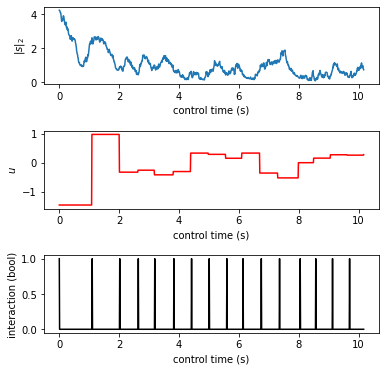

In [17]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [ ]:
with open('../csv/batch.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(batch)
    
with open('../csv/batch.csv', 'w') as f:
    reader = csv.reader(f)
    batch = np.array([r for r in reader]).astype('float')